In [65]:
%load_ext autoreload
%autoreload 2

# Add other paths
import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import helper_libraries.results_tools as results_tools
import multiprocessing
import functools
import warnings
from stargazer import stargazer
from tqdm.auto import tqdm

warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import data

## Returns and Spreads

In [2]:
# Load returns and spreads
fret_df, hrf_df = results_tools.load_mkt_rf_returns()
spread_df = results_tools.load_spreads()

## Trading

In [3]:
# Year to start trading
start_year = '2004'

# Define strategies and models
strategies_list = [
    "Market",
    "Sign",
    "Positive",
    "Tanh",
    "MS Strategy 2",
    "MS Strategy 1",
]
model_list = [
    "Benchmark",
    "LR",
    "LR_PCA_select",
    "LR_Lasso_select",
    "Lasso",
    "Enet"
]

In [336]:
# Load model results
forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
    overnight=False,
    oos_periods=2,
    predictors="All",
    debug=True,
)

# Filter data
forecast_oss_filter_df = forecast_oss_df.loc[start_year:].copy()
forecast_ins_filter_df = forecast_ins_df.loc[:str(int(start_year)-1)].copy()
fret_filter_df = fret_df.loc[start_year:].copy()
hrf_filter_df = hrf_df.loc[start_year:].copy()

# Trading strategies
(
    oss_results_all_df,
    oss_returns_all_df,
    oss_weights_all_df,
    oss_retpred_all_df,
) = results_tools.get_trading_results(
    forecast_oss_filter_df,
    forecast_ins_filter_df,
    spread_df,
    fret_filter_df["ff__mkt"],
    hrf_filter_df["rf"],
    strategies_list,
    model_list,
    hold_cash=True,
)

Loading the following model results...
--------------------------------------------------
Folder           main
Overnight       False
OOSPeriods          2
Predictors        All
Notes            Done
Asset         ff__mkt
--------------------------------------------------


## JLN Uncertainty

In [337]:
# Load uncertainty measurse from Jurado, Ludvigson, Ng
uncertainty_financial_df = pd.read_excel('../../data/jln/FinancialUncertaintyToCirculate.xlsx')
uncertainty_macro_df = pd.read_excel('../../data/jln/MacroUncertaintyToCirculate.xlsx')
uncertainty_real_df = pd.read_excel('../../data/jln/RealUncertaintyToCirculate.xlsx')

In [338]:
## Clean up
# Fix date index
uncertainty_financial_df.index = pd.to_datetime(uncertainty_financial_df['Date']) + pd.tseries.offsets.MonthEnd(0)
uncertainty_macro_df.index = pd.to_datetime(uncertainty_macro_df['Date']) + pd.tseries.offsets.MonthEnd(0)
uncertainty_real_df.index = pd.to_datetime(uncertainty_real_df['Date']) + pd.tseries.offsets.MonthEnd(0)

# Setup variables
uncertainty_financial_df['financial_uncertainty'] = uncertainty_financial_df['h=1'] / np.std(uncertainty_financial_df['h=1'])
uncertainty_macro_df['macro_uncertainty'] = uncertainty_macro_df['h=1'] / np.std(uncertainty_macro_df['h=1'])
uncertainty_real_df['real_uncertainty'] = uncertainty_real_df['h=1'] / np.std(uncertainty_real_df['h=1'])

## BEX Uncertainty

In [339]:
# Load uncertainty measurse from Bekaert, Engstrom, Xu
uncertainty_econ_df = pd.read_excel(
    "../../data/bex/BEX_Indices_20220301.xlsx", sheet_name="DATA_PLOT_monthly"
)[["yyyymm", "unc_bex_PAPER"]]
index_ra_df = pd.read_excel(
    "../../data/bex/BEX_Indices_20220301.xlsx", sheet_name="DATA_PLOT_monthly"
)[["yyyymm", "ra_bex_PAPER"]]

In [340]:
## Clean up
# Fix date index
uncertainty_econ_df.index = pd.to_datetime(
    uncertainty_econ_df["yyyymm"], format="%Y%m"
) + pd.tseries.offsets.MonthEnd(0)
index_ra_df.index = pd.to_datetime(
    index_ra_df["yyyymm"], format="%Y%m"
) + pd.tseries.offsets.MonthEnd(0)

# Setup variables
uncertainty_econ_df["bex_uncertainty"] = uncertainty_econ_df["unc_bex_PAPER"] / np.std(
    uncertainty_econ_df["unc_bex_PAPER"]
)
index_ra_df["bex_risk_aversion"] = index_ra_df["ra_bex_PAPER"] / np.std(
    index_ra_df["ra_bex_PAPER"]
)

## FRED

In [341]:
# Load uncertainty measurse from FRED
fred_gdp_df = pd.read_excel(
    "../../data/fred/GDP.xls", skiprows = 10)
fred_unemp_df = pd.read_excel(
    "../../data/fred/UNRATE.xls", skiprows = 10)

In [342]:
## Clean up
# Fix date index
fred_gdp_df.index = pd.to_datetime(
    fred_gdp_df["observation_date"]
) + pd.tseries.offsets.MonthEnd(0)
fred_unemp_df.index = pd.to_datetime(
    fred_unemp_df["observation_date"]
) + pd.tseries.offsets.MonthEnd(0)

# Setup variables
fred_gdp_df["gdp_growth"] = fred_gdp_df["GDP_PCH"] / np.std(
    fred_gdp_df["GDP_PCH"]
)
fred_unemp_df["unemp_change"] = fred_unemp_df["UNRATE_PCH"] / np.std(
    fred_unemp_df["UNRATE_PCH"]
)

# Analysis

## Main strategy

### Prep data

In [231]:
# Select model strat
model = 'Enet'
strategy = 'MS Strategy 1'

<AxesSubplot:xlabel='datetime'>

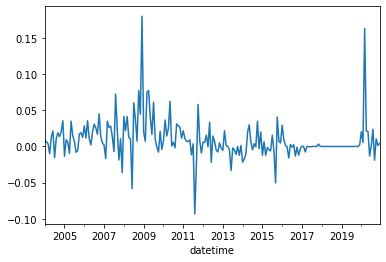

In [232]:
returns_monthly_series = oss_returns_all_df[model][strategy].groupby(pd.Grouper(freq = '1m')).sum()
returns_monthly_diff_series = returns_monthly_series - oss_returns_all_df[model]['Market'].groupby(pd.Grouper(freq = '1m')).sum()
returns_monthly_mkt_series = oss_returns_all_df[model]['Market'].groupby(pd.Grouper(freq = '1m')).sum()
returns_monthly_series.plot()

In [233]:
# Returns
returns_df = (
    returns_monthly_diff_series.to_frame("diff")
    .join(returns_monthly_series.to_frame("returns"))
    .join(returns_monthly_mkt_series.to_frame("mkt"))
)

# Returns with covariates for regressions
reg_df = returns_df.join(uncertainty_financial_df["financial_uncertainty"].shift(-1))
reg_df = reg_df.join(uncertainty_macro_df["macro_uncertainty"].shift(-1))
reg_df = reg_df.join(uncertainty_real_df["real_uncertainty"].shift(-1))
reg_df = reg_df.join(uncertainty_econ_df["bex_uncertainty"].shift(-1))
reg_df = reg_df.join(index_ra_df["bex_risk_aversion"].shift(-1))

### Regressions

In [110]:
fit_fin_mkt = smf.ols("mkt ~ financial_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)
fit_fin_diff = smf.ols("diff ~ financial_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)
fit_fin_returns = smf.ols("returns ~ financial_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)

fit_macro_mkt = smf.ols("mkt ~ macro_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)
fit_macro_diff = smf.ols("diff ~ macro_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)
fit_macro_returns = smf.ols("returns ~ macro_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)

fit_real_mkt = smf.ols("mkt ~ real_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)
fit_real_diff = smf.ols("diff ~ real_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)
fit_real_returns = smf.ols("returns ~ real_uncertainty", reg_df).fit(
    cov_type="HAC", cov_kwds={"maxlags": 12}
)

fit_all_mkt = smf.ols(
    "mkt ~ financial_uncertainty + macro_uncertainty + real_uncertainty", reg_df
).fit(cov_type="HAC", cov_kwds={"maxlags": 12})
fit_all_diff = smf.ols(
    "diff ~ financial_uncertainty + macro_uncertainty + real_uncertainty", reg_df
).fit(cov_type="HAC", cov_kwds={"maxlags": 12})
fit_all_returns = smf.ols(
    "returns ~ financial_uncertainty + macro_uncertainty + real_uncertainty", reg_df
).fit(cov_type="HAC", cov_kwds={"maxlags": 12})

In [141]:
sg = stargazer.Stargazer([fit_fin_mkt, fit_fin_returns, fit_fin_diff,
                    fit_macro_mkt, fit_macro_returns, fit_macro_diff,
                    fit_real_mkt, fit_real_returns, fit_real_diff,
                    # fit_all_mkt, fit_all_returns, fit_all_diff,
                    ])
sg.column_labels = ['Market', 'ENet-MS1', 'Diff']*3
sg.column_separators = [1]*9
sg.cov_map = {'financial_uncertainty': 'Financial Uncertainty',
              'macro_uncertainty':    'Macro Uncertainty',
              'real_uncertainty':  'Real Uncertainty',}

In [142]:
print(sg.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccccccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
\\[-1.8ex] & \multicolumn{1}{c}{Market} & \multicolumn{1}{c}{ENet-MS1} & \multicolumn{1}{c}{Diff} & \multicolumn{1}{c}{Market} & \multicolumn{1}{c}{ENet-MS1} & \multicolumn{1}{c}{Diff} & \multicolumn{1}{c}{Market} & \multicolumn{1}{c}{ENet-MS1} & \multicolumn{1}{c}{Diff}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8) & (9) \\
\hline \\[-1.8ex]
 Intercept & 0.023$^{*}$ & -0.028$^{*}$ & -0.096$^{***}$ & 0.016$^{}$ & -0.042$^{***}$ & -0.112$^{***}$ & 0.006$^{}$ & -0.023$^{}$ & -0.070$^{**}$ \\
  & (0.013) & (0.015) & (0.035) & (0.017) & (0.014) & (0.038) & (0.011) & (0.014) & (0.036) \\
 Financial Uncertainty & -0.025$^{}$ & 0.042$^{**}$ & 0.128$^{***}$ & & & & & & \\
  & (0.016) & (0.017) & (0.041) & & & & & & \\
 Macro Uncertainty & & & & -0.022$^{}$ & 0.076$^{***}$ & 0.195$^{***}$ & & & \\
  & & & & (0.027) & (0.022) & (0.061) & & & \\
 Real Uncertainty & &

## All pairs

In [343]:
def run_reg(reg_df, lhs_var, rhs_var):
    
    fit = smf.ols(f"{lhs_var} ~ {rhs_var}", reg_df).fit(
        cov_type="HAC", cov_kwds={"maxlags": 12}
    )
    
    # Deal with gdp being lower freq
    if 'gdp_growth' in rhs_var:
        reg_alt_df = reg_df.fillna(0)[[lhs_var, rhs_var]].groupby(pd.Grouper(freq = '3m')).sum()
        fit = smf.ols(f"{lhs_var} ~ {rhs_var}", reg_alt_df).fit(
            cov_type="HAC", cov_kwds={"maxlags": 4}
        )
    
    
    return fit

In [344]:
# Params
strategy = "MS Strategy 1"

# Results storage
regressor_name_list = [
    "Financial Uncertainty",
    "Macro Uncertainty",
    "Real Uncertainty",
    "Econ Uncertainty",
    "Risk Aversion",
    "GDP Growth",
    "Unemployment Change",
]
regressor_list = [
    "financial_uncertainty",
    "macro_uncertainty",
    "real_uncertainty",
    "bex_uncertainty",
    "bex_risk_aversion",
    "gdp_growth",
    "unemp_change",
]
results_params_df = pd.DataFrame([], columns=model_list, index=regressor_name_list)
results_tstats_df = pd.DataFrame([], columns=model_list, index=regressor_name_list)
results_r2_df = pd.DataFrame([], columns=model_list, index=regressor_name_list)

for model in tqdm(model_list):

    returns_monthly_series = (
        oss_returns_all_df[model][strategy].groupby(pd.Grouper(freq="1m")).sum()
    )
    returns_monthly_diff_series = (
        returns_monthly_series
        - oss_returns_all_df[model]["Market"].groupby(pd.Grouper(freq="1m")).sum()
    )
    returns_monthly_mkt_series = (
        oss_returns_all_df[model]["Market"].groupby(pd.Grouper(freq="1m")).sum()
    )

    # Returns
    returns_df = (
        returns_monthly_diff_series.to_frame("diff")
        .join(returns_monthly_series.to_frame("returns"))
        .join(returns_monthly_mkt_series.to_frame("mkt"))
    )

    # Returns with covariates for regressions
    reg_df = returns_df.join(uncertainty_financial_df["financial_uncertainty"].shift(-1))
    reg_df = reg_df.join(uncertainty_macro_df["macro_uncertainty"].shift(-1))
    reg_df = reg_df.join(uncertainty_real_df["real_uncertainty"].shift(-1))
    reg_df = reg_df.join(uncertainty_econ_df["bex_uncertainty"].shift(-1))
    reg_df = reg_df.join(index_ra_df["bex_risk_aversion"].shift(-1))
    reg_df = reg_df.join(fred_gdp_df["gdp_growth"].shift(3))
    reg_df = reg_df.join(fred_unemp_df["unemp_change"].shift(1))

    # Regressions
    for i in range(len(regressor_list)):
        
        fit = run_reg(reg_df, 'diff', regressor_list[i])
        results_params_df.loc[regressor_name_list[i], model] = fit.params[-1]
        results_tstats_df.loc[regressor_name_list[i], model] = fit.tvalues[-1]
        results_r2_df.loc[regressor_name_list[i], model] = fit.rsquared

  0%|          | 0/6 [00:00<?, ?it/s]

In [309]:
results_params_df

,Benchmark,LR,LR_PCA_select,LR_Lasso_select,Lasso,Enet
Financial Uncertainty,0.004764,0.009397,0.010341,-0.00041,0.012484,0.011207
Macro Uncertainty,0.003279,0.007891,0.008146,-0.000146,0.011231,0.010552
Real Uncertainty,0.001636,0.004268,0.004739,-0.000196,0.007215,0.006078
Econ Uncertainty,0.005286,0.012949,0.014269,-0.000525,0.015372,0.01424
Risk Aversion,0.006082,0.010819,0.013671,-0.000278,0.014646,0.013334
GDP Growth,0.011665,-0.004211,0.002279,0.005874,-0.006002,0.001302
Unemployment Change,0.001341,-0.000521,0.001853,0.000012,0.001673,0.001423


In [310]:
results_tstats_df

,Benchmark,LR,LR_PCA_select,LR_Lasso_select,Lasso,Enet
Financial Uncertainty,2.108621,2.38227,2.17218,-1.537654,3.336921,2.604438
Macro Uncertainty,1.287838,1.734731,1.520491,-0.945548,2.642489,2.255163
Real Uncertainty,0.826557,1.133821,1.136044,-1.254574,1.854779,1.508614
Econ Uncertainty,1.929355,4.461856,2.920784,-1.353219,5.011375,3.819573
Risk Aversion,3.473388,6.094102,4.33053,-1.456621,6.82387,4.716805
GDP Growth,1.418066,-0.571001,0.185128,1.437628,-0.443004,0.100108
Unemployment Change,4.376465,-0.670439,3.643839,0.25821,2.5841,2.260262


In [311]:
results_r2_df

,Benchmark,LR,LR_PCA_select,LR_Lasso_select,Lasso,Enet
Financial Uncertainty,0.039836,0.128264,0.103582,0.008012,0.173101,0.144836
Macro Uncertainty,0.023634,0.113262,0.080482,0.001267,0.175406,0.160787
Real Uncertainty,0.006717,0.037825,0.031091,0.002623,0.082641,0.060911
Econ Uncertainty,0.04085,0.202896,0.164288,0.010925,0.218629,0.19482
Risk Aversion,0.069682,0.182473,0.194275,0.003949,0.255667,0.220054
GDP Growth,0.014144,0.001282,0.000281,0.095377,0.002018,0.000099
Unemployment Change,0.00539,0.000674,0.005686,0.000011,0.005316,0.003989
